In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
from geopy.distance import geodesic
from io import StringIO

In [16]:
def load_bridge_data(csv_file_path):
    """Load bridge sensor data from CSV file"""
    df = pd.read_csv(csv_file_path)
    return df

In [17]:
def calculate_3d_distance(coord1, coord2):
    """Calculate 3D distance considering lat, lon, and altitude"""
 
    horizontal_dist = geodesic((coord1[0], coord1[1]), (coord2[0], coord2[1])).meters
    
    # Calculate vertical distance
    vertical_dist = abs(coord1[2] - coord2[2])
    
    # Calculate 3D Euclidean distance
    distance_3d = np.sqrt(horizontal_dist**2 + vertical_dist**2)
    
    return distance_3d

In [18]:
def get_stiffness_value(src_type, tgt_type, distance_m):
    """
    Get stiffness value based on structural element types and distance
    pier: 1.2, girder: 1.0, pylon: 1.5, ground: 0.8
    """
    # Define base stiffness for each type
    type_stiffness = {
        'pier': 1.2,
        'girder': 1.0, 
        'pylon': 1.5,
        'ground': 0.8
    }
    
    # Special cases for structural connections (most important)
    if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.1  # Pier-girder connection (support connection)
    elif ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.3  # Pylon-girder connection (main support)
    
    # For same-type connections, use the type's stiffness
    if src_type == tgt_type:
        base_stiffness = type_stiffness.get(src_type, 1.0)
        # Reduce stiffness for very long connections
        distance_factor = max(0.5, 1.0 - (distance_m / 500.0))  # Reduce if >500m
        return round(base_stiffness * distance_factor, 2)
    
    # For mixed connections, use average of both types
    src_stiff = type_stiffness.get(src_type, 1.0)
    tgt_stiff = type_stiffness.get(tgt_type, 1.0)
    return round((src_stiff + tgt_stiff) / 2, 2)

In [19]:
def classify_edge_importance_strict(src_type, tgt_type, distance_m, is_in_mst=False, 
                                  structural_score=0):
    """
    STRICT classification to minimize critical edges for monitoring networks:
    - Critical (Red): Only the most essential monitoring connections (< 6 total)
    - Important (Green): MST edges + key redundant connections
    - Optional (Blue): All other connections
    """
    
    # VERY STRICT Critical connections (RED) - Maximum 6 edges total
    # Only the shortest, most structurally important connections
    if distance_m < 15:  # Must be very close
        if ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
            return 'critical'  # Only short pylon-girder connections
        elif ('ground' in [src_type, tgt_type]) and ('pier' in [src_type, tgt_type]):
            if structural_score > 0.8:  # Only highest scoring ground-pier
                return 'critical'
        elif ('ground' in [src_type, tgt_type]) and ('pylon' in [src_type, tgt_type]):
            return 'critical'  # Short ground-pylon connections
    
    # Important connections (GREEN) - MST + selected structural
    if is_in_mst:
        return 'important'  # All MST edges are important
    elif distance_m < 25:  # Moderate distance threshold
        if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
            return 'important'  # Only short pier-girder connections
        elif src_type == 'girder' and tgt_type == 'girder':
            return 'important'  # Short girder-girder connections
    
    # All others are optional (BLUE)
    return 'optional'

In [20]:
def calculate_structural_importance_score(src_type, tgt_type, distance_m, df, src_id, tgt_id):
    """
    Calculate a structural importance score (0-1) for prioritizing critical edges
    Higher score = more important for monitoring
    """
    score = 0.0
    
    # Base score by connection type
    type_scores = {
        ('pylon', 'girder'): 0.9,
        ('ground', 'pylon'): 0.8,
        ('ground', 'pier'): 0.7,
        ('pier', 'girder'): 0.6,
        ('girder', 'girder'): 0.4,
        ('pier', 'pier'): 0.3
    }
    
    conn_key = tuple(sorted([src_type, tgt_type]))
    score += type_scores.get(conn_key, 0.1)
    
    # Distance penalty (closer is better)
    distance_score = max(0, 1.0 - (distance_m / 50.0))
    score *= distance_score
    
    # Altitude difference bonus (monitoring vertical structure)
    src_alt = df[df['node_id'] == src_id]['altitude_m'].iloc[0]
    tgt_alt = df[df['node_id'] == tgt_id]['altitude_m'].iloc[0]
    alt_diff = abs(src_alt - tgt_alt)
    
    if alt_diff > 5:  # Significant vertical monitoring
        score += 0.2
    
    return min(1.0, score)


In [21]:
def calculate_structural_penalty(src_type, tgt_type):
    """
    Calculate penalty for structurally important connections
    Lower penalty = higher priority in MST
    """
    # Critical structural connections get very low penalty (high priority)
    if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 0.1  # Pier-girder connections are critical
    elif ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 0.05  # Pylon-girder connections are most critical
    elif ('ground' in [src_type, tgt_type]) and ('pier' in [src_type, tgt_type]):
        return 0.08  # Ground-pier connections are critical
    elif ('ground' in [src_type, tgt_type]) and ('pylon' in [src_type, tgt_type]):
        return 0.06  # Ground-pylon connections are critical
    
    # Same-type connections get moderate penalty
    if src_type == tgt_type:
        type_priorities = {'pylon': 0.3, 'girder': 0.4, 'pier': 0.5, 'ground': 0.7}
        return type_priorities.get(src_type, 0.6)
    
    # Other mixed connections get higher penalty
    return 0.8

In [22]:
def create_complete_graph_with_weights(df):
    """Create a complete graph with all possible edges and their weights"""
    coords = df[['latitude', 'longitude', 'altitude_m']].values
    node_ids = df['node_id'].tolist()
    n_nodes = len(df)
    
    all_edges = []
    
    print(f"\nCreating complete graph with {n_nodes} nodes...")
    print(f"Total possible edges: {n_nodes * (n_nodes - 1) // 2}")
    
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            src_id = node_ids[i]
            tgt_id = node_ids[j]
            src_type = df.iloc[i]['type']
            tgt_type = df.iloc[j]['type']
            
            # Calculate 3D distance
            distance = calculate_3d_distance(coords[i], coords[j])
            
            # Calculate structural penalty
            structural_penalty = calculate_structural_penalty(src_type, tgt_type)
            
            # Calculate structural importance score
            struct_score = calculate_structural_importance_score(
                src_type, tgt_type, distance, df, src_id, tgt_id)
            
            # Combined weight: distance with structural importance factor
            # Lower weight = higher priority for inclusion in MST
            weight = distance * structural_penalty
            
            # Get stiffness value
            stiffness = get_stiffness_value(src_type, tgt_type, distance)
            
            # Determine edge type
            if src_type == tgt_type:
                edge_type = src_type
            else:
                edge_type = "support"
            
            all_edges.append({
                'source': src_id,
                'target': tgt_id,
                'weight': weight,
                'distance_m': round(distance, 2),
                'structural_penalty': structural_penalty,
                'structural_score': struct_score,
                'type': edge_type,
                'stiffness': stiffness,
                'src_type': src_type,
                'tgt_type': tgt_type
            })
    
    return all_edges

In [23]:
def create_optimized_monitoring_network(df, algorithm='kruskal'):
    """
    Create an optimized monitoring network with strict critical edge limits
    """
    print(f"\n=== Optimized Monitoring Network Creation ===")
    print("Goal: Efficient monitoring with minimal redundancy")
    
    # Get all possible edges with weights
    all_edges = create_complete_graph_with_weights(df)
    
    # Create NetworkX graph from all edges
    G_complete = nx.Graph()
    
    # Add nodes
    for _, row in df.iterrows():
        G_complete.add_node(row['node_id'], 
                           type=row['type'],
                           pos=(row['longitude'], row['latitude']),
                           altitude=row['altitude_m'])
    
    # Add all edges with weights
    for edge in all_edges:
        G_complete.add_edge(edge['source'], edge['target'], 
                           weight=edge['weight'],
                           distance_m=edge['distance_m'],
                           structural_penalty=edge['structural_penalty'],
                           structural_score=edge['structural_score'],
                           type=edge['type'],
                           stiffness=edge['stiffness'],
                           src_type=edge['src_type'],
                           tgt_type=edge['tgt_type'])
    
    # Apply MST algorithm
    if algorithm == 'kruskal':
        mst_edges = nx.minimum_spanning_tree(G_complete, algorithm='kruskal')
    else:  # prim
        mst_edges = nx.minimum_spanning_tree(G_complete, algorithm='prim')
    
    # Get MST edge set for lookup
    mst_edge_set = set()
    for edge in mst_edges.edges():
        mst_edge_set.add(tuple(sorted(edge)))
    
    # Step 1: Identify potential critical edges based on strict criteria
    potential_critical = []
    for edge in all_edges:
        struct_score = edge['structural_score']
        if struct_score > 0.7 and edge['distance_m'] < 20:  # Very selective
            potential_critical.append(edge)
    
    # Sort by structural score and limit to top 6
    potential_critical.sort(key=lambda x: x['structural_score'], reverse=True)
    max_critical = min(6, len(potential_critical))
    selected_critical = potential_critical[:max_critical]
    
    print(f"\nSelected {len(selected_critical)} critical edges (max 6):")
    for edge in selected_critical:
        print(f"  {edge['source']} ↔ {edge['target']} ({edge['src_type']}-{edge['tgt_type']}) "
              f"- {edge['distance_m']:.1f}m, score: {edge['structural_score']:.2f}")
    
    # Step 2: Classify all edges with MST information
    final_edges = []
    edge_set = set()
    
    critical_edges = []
    important_edges = []
    optional_edges = []
    
    # Mark selected critical edges
    critical_edge_tuples = set()
    for edge in selected_critical:
        critical_edge_tuples.add(tuple(sorted((edge['source'], edge['target']))))
    
    for edge in all_edges:
        edge_tuple = tuple(sorted((edge['source'], edge['target'])))
        is_in_mst = edge_tuple in mst_edge_set
        is_critical = edge_tuple in critical_edge_tuples
        
        # Classify with strict criteria
        if is_critical:
            importance = 'critical'
        else:
            importance = classify_edge_importance_strict(
                edge['src_type'], edge['tgt_type'], edge['distance_m'], 
                is_in_mst, edge['structural_score'])
        
        edge['importance'] = importance
        edge['in_mst'] = is_in_mst
        
        # Separate by importance
        if importance == 'critical':
            critical_edges.append(edge)
        elif importance == 'important':
            important_edges.append(edge)
        else:
            optional_edges.append(edge)
    
    # Step 3: Build final network - Start with critical edges
    print(f"\nBuilding optimized monitoring network:")
    
    # Add all critical edges
    for edge in critical_edges:
        edge_tuple = tuple(sorted((edge['source'], edge['target'])))
        if edge_tuple not in edge_set:
            final_edges.append(edge)
            edge_set.add(edge_tuple)
    
    print(f"✓ Added {len(critical_edges)} critical edges")
    
    # Add MST edges that aren't already included
    mst_added = 0
    for edge in all_edges:
        edge_tuple = tuple(sorted((edge['source'], edge['target'])))
        if edge['in_mst'] and edge_tuple not in edge_set:
            edge['importance'] = 'important'  # MST edges are important
            final_edges.append(edge)
            edge_set.add(edge_tuple)
            mst_added += 1
    
    print(f"✓ Added {mst_added} MST edges for connectivity")
    
    # Add selected important edges for redundancy (limit to prevent mesh)
    important_non_mst = [e for e in important_edges if not e['in_mst']]
    important_non_mst.sort(key=lambda x: (x['structural_score'], -x['distance_m']), reverse=True)
    
    redundancy_limit = min(3, len(important_non_mst))  # Max 3 additional
    redundancy_added = 0
    
    for edge in important_non_mst[:redundancy_limit]:
        edge_tuple = tuple(sorted((edge['source'], edge['target'])))
        if edge_tuple not in edge_set:
            final_edges.append(edge)
            edge_set.add(edge_tuple)
            redundancy_added += 1
    
    print(f"✓ Added {redundancy_added} redundancy edges")
    
    return final_edges, critical_edges, important_edges, optional_edges

In [24]:
def analyze_optimized_network(df, final_edges):
    """Analyze the optimized monitoring network"""
    print(f"\n=== Optimized Network Analysis ===")
    
    # Count by importance
    importance_counts = {'critical': 0, 'important': 0, 'optional': 0}
    for edge in final_edges:
        importance_counts[edge['importance']] += 1
    
    print(f"Final network composition:")
    print(f"  🔴 Critical (RED): {importance_counts['critical']} edges")
    print(f"  🟢 Important (GREEN): {importance_counts['important']} edges") 
    print(f"  🔵 Optional (BLUE): {importance_counts['optional']} edges")
    print(f"  📊 Total: {len(final_edges)} edges")
    
    # Network efficiency metrics
    n_nodes = len(df)
    max_possible = n_nodes * (n_nodes - 1) // 2
    efficiency = len(final_edges) / max_possible
    
    print(f"\nNetwork efficiency:")
    print(f"  Nodes: {n_nodes}")
    print(f"  Selected edges: {len(final_edges)} / {max_possible} possible")
    print(f"  Network density: {efficiency:.3f}")
    print(f"  Connectivity ratio: {len(final_edges) / (n_nodes - 1):.2f} (1.0 = minimal spanning)")
    
    # Show critical connections
    critical_conns = [e for e in final_edges if e['importance'] == 'critical']
    print(f"\n🔴 Critical monitoring connections:")
    for edge in sorted(critical_conns, key=lambda x: x['structural_score'], reverse=True):
        print(f"  {edge['source']} ↔ {edge['target']} ({edge['src_type']}-{edge['tgt_type']}) "
              f"- {edge['distance_m']:.1f}m (score: {edge['structural_score']:.2f})")

In [25]:
def visualize_optimized_network(G, df, title="Optimized Monitoring Network"):
    """Create enhanced 2D and 3D visualizations with improved color coding"""
    fig = plt.figure(figsize=(20, 10))
    
    # 2D Plot
    ax1 = plt.subplot(121)
    pos = nx.get_node_attributes(G, 'pos')
    
    # Color nodes by type with better contrast
    node_colors = []
    node_color_map = {'girder': '#FFD700', 'pier': '#87CEEB', 'ground': '#90EE90', 'pylon': '#FA8072'}
    for node in G.nodes():
        node_colors.append(node_color_map[G.nodes[node]['type']])
    
    # Separate edges by importance for layered drawing
    critical_edges = []
    important_edges = []
    optional_edges = []
    
    for edge in G.edges():
        importance = G.edges[edge].get('importance', 'optional')
        if importance == 'critical':
            critical_edges.append(edge)
        elif importance == 'important':
            important_edges.append(edge)
        else:
            optional_edges.append(edge)
    
    # Draw edges in layers with better styling
    if optional_edges:
        nx.draw_networkx_edges(G, pos, edgelist=optional_edges, edge_color='#4169E1', 
                              width=1.5, alpha=0.6, style='dashed', ax=ax1)
    if important_edges:
        nx.draw_networkx_edges(G, pos, edgelist=important_edges, edge_color='#32CD32', 
                              width=2.5, alpha=0.8, ax=ax1)
    if critical_edges:
        nx.draw_networkx_edges(G, pos, edgelist=critical_edges, edge_color='#DC143C', 
                              width=4.0, alpha=1.0, ax=ax1)
    
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600, 
                          edgecolors='black', linewidths=2, ax=ax1)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax1)
    
    ax1.set_title(f'{title}\n🔴 Critical • 🟢 Important • 🔵 Optional', fontsize=14)
    ax1.set_aspect('equal')
    
    # Create legends
    from matplotlib.lines import Line2D
    edge_legend = [
        Line2D([0], [0], color='#DC143C', linewidth=4, label='Critical (Essential)'),
        Line2D([0], [0], color='#32CD32', linewidth=2.5, label='Important (MST + Key)'), 
        Line2D([0], [0], color='#4169E1', linewidth=1.5, linestyle='--', label='Optional (Redundancy)')
    ]
    ax1.legend(handles=edge_legend, loc='upper right', title='Edge Classification')
    
    # 3D Plot
    ax3d = fig.add_subplot(122, projection='3d')
    
    # Plot nodes in 3D
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        z = G.nodes[node]['altitude']
        color = node_color_map[G.nodes[node]['type']]
        ax3d.scatter(x, y, z, c=color, s=300, edgecolors='black', linewidths=2)
        ax3d.text(x, y, z + 1, str(node), fontsize=9, weight='bold')
    
    # Draw edges in 3D with improved styling
    for edge in G.edges():
        x_coords = [G.nodes[edge[0]]['pos'][0], G.nodes[edge[1]]['pos'][0]]
        y_coords = [G.nodes[edge[0]]['pos'][1], G.nodes[edge[1]]['pos'][1]]
        z_coords = [G.nodes[edge[0]]['altitude'], G.nodes[edge[1]]['altitude']]
        
        importance = G.edges[edge].get('importance', 'optional')
        
        if importance == 'critical':
            color, width, alpha, style = '#DC143C', 5.0, 1.0, '-'
        elif importance == 'important':
            color, width, alpha, style = '#32CD32', 3.0, 0.8, '-'
        else:
            color, width, alpha, style = '#4169E1', 2.0, 0.6, '--'
            
        ax3d.plot(x_coords, y_coords, z_coords, color=color, 
                 alpha=alpha, linewidth=width, linestyle=style)
    
    ax3d.set_xlabel('Longitude')
    ax3d.set_ylabel('Latitude') 
    ax3d.set_zlabel('Altitude (m)')
    ax3d.set_title(f'{title} - 3D View')
    ax3d.set_box_aspect([4,2,1])
    
    plt.tight_layout()
    plt.show()

In [26]:
def create_networkx_graph(df, edges):
    """Create NetworkX graph from nodes and edges"""
    G = nx.Graph()
    
    # Add nodes with attributes
    for _, row in df.iterrows():
        G.add_node(row['node_id'], 
                  type=row['type'],
                  pos=(row['longitude'], row['latitude']),
                  altitude=row['altitude_m'])
    
    # Add edges with attributes
    for edge in edges:
        G.add_edge(edge['source'], edge['target'],
                  type=edge['type'],
                  stiffness=edge['stiffness'],
                  distance_m=edge['distance_m'],
                  structural_penalty=edge.get('structural_penalty', 0.5),
                  structural_score=edge.get('structural_score', 0.5),
                  weight=edge.get('weight', edge['distance_m']),
                  importance=edge.get('importance', 'optional'),
                  in_mst=edge.get('in_mst', False))
    
    return G

In [27]:
def save_edges_csv(edges, filename):
    """Save edges to CSV file with all attributes"""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['source', 'target', 'type', 'stiffness', 'distance_m', 
                        'structural_penalty', 'structural_score', 'weight', 
                        'src_type', 'tgt_type', 'importance', 'in_mst'])
        for edge in edges:
            writer.writerow([edge['source'], edge['target'], edge['type'], 
                           edge['stiffness'], edge['distance_m'], edge['structural_penalty'],
                           edge.get('structural_score', 0), edge['weight'], 
                           edge['src_type'], edge['tgt_type'],
                           edge['importance'], edge.get('in_mst', False)])
    print(f"📁 Edges saved to {filename}")

=== OPTIMIZED Bridge Sensor Monitoring Network ===
🎯 Goal: Efficient monitoring with minimal mesh density
📊 Loaded bridge sensor data:
   Total sensors: 26
   Sensor types: {'girder': 12, 'pier': 8, 'ground': 6}

=== IMPROVED Classification System ===
🔴 CRITICAL (Red): Max 6 essential connections only
   • Highest structural importance score (>0.7)
   • Distance < 20m
   • Key monitoring points
🟢 IMPORTANT (Green): MST backbone + key redundancy
   • All MST-selected edges for connectivity
   • Selected short structural connections
🔵 OPTIONAL (Blue): Limited additional redundancy
   • Max 3 additional connections
   • Prevents mesh density

=== Optimized Monitoring Network Creation ===
Goal: Efficient monitoring with minimal redundancy

Creating complete graph with 26 nodes...
Total possible edges: 325

Selected 0 critical edges (max 6):

Building optimized monitoring network:
✓ Added 0 critical edges
✓ Added 25 MST edges for connectivity
✓ Added 3 redundancy edges

=== Optimized Networ

/var/folders/dd/0g1xrlqs14xb557z_t42byhc0000gn/T/ipykernel_8242/3901391202.py:92: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dd/0g1xrlqs14xb557z_t42byhc0000gn/T/ipykernel_8242/3901391202.py:92: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dd/0g1xrlqs14xb557z_t42byhc0000gn/T/ipykernel_8242/3901391202.py:92: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/prom_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/prom_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/an

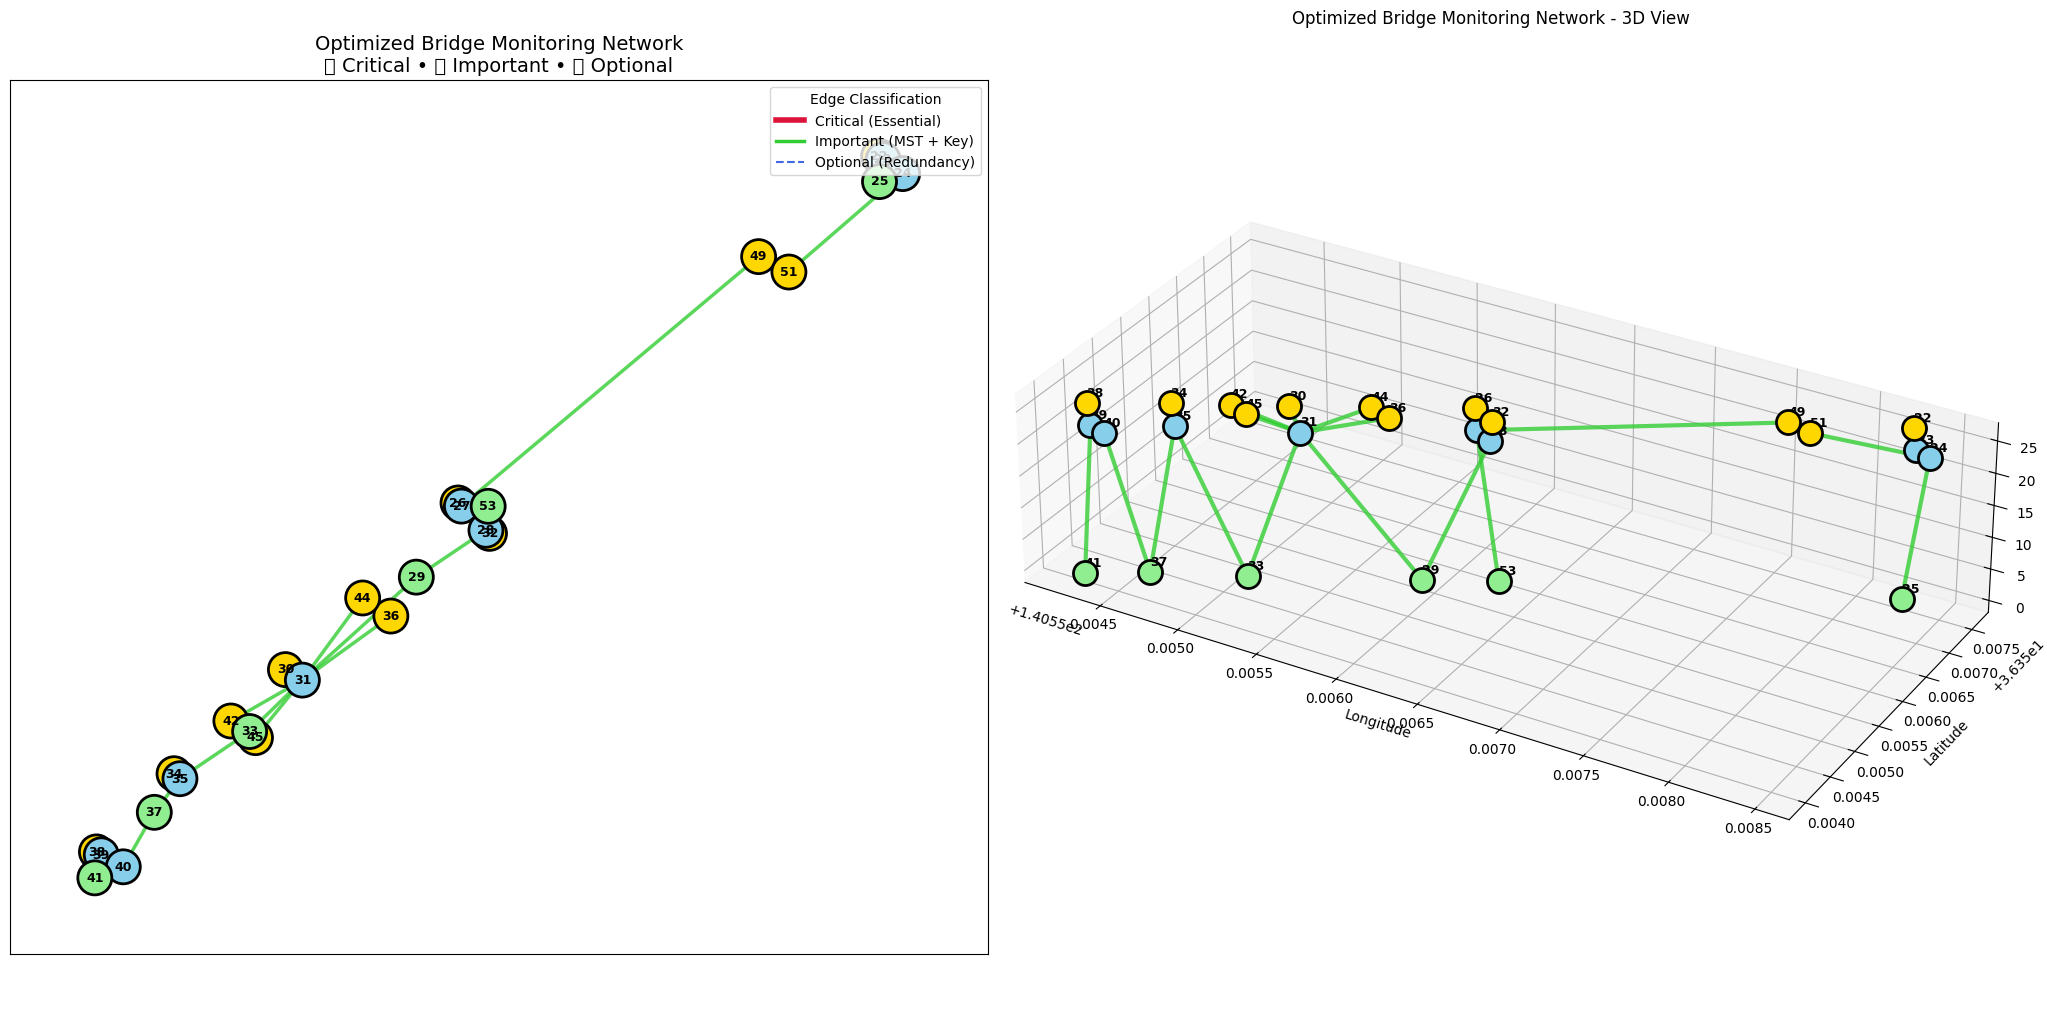

📁 Edges saved to bridge_optimized_monitoring_network.csv

=== 🎉 OPTIMIZATION SUMMARY ===
✅ Strict critical edge limits (≤6 red edges)
✅ MST provides efficient connectivity backbone
✅ Minimal redundancy prevents mesh density
✅ Structural importance scoring prioritizes key connections
✅ Balanced monitoring coverage vs. efficiency

🔍 Network Validation:
   Connected: ✅ Yes
   Total edges: 28
   Density: 0.086 (lower = more efficient)
   Critical edges: 0

📁 Generated file: bridge_optimized_monitoring_network.csv


In [28]:
if __name__ == "__main__":
    # Bridge sensor data
    csv_data = """node_id,type,latitude,longitude,altitude_m
22,girder,36.35760246,140.5582758,25.9
26,girder,36.35584565,140.5561452,25.9
30,girder,36.35500155,140.555271,25.9
32,girder,36.35569158,140.5563046,25.9
34,girder,36.35447425,140.5547067,25.9
36,girder,36.35527276,140.5558051,25.9
38,girder,36.35407821,140.5543137,25.9
42,girder,36.35474124,140.5549947,25.9
44,girder,36.35536433,140.5556622,25.9
45,girder,36.3546569,140.5551193,25.9
49,girder,36.35709344,140.5576679,25.9
51,girder,36.35701549,140.5578214,25.9
23,pier,36.35758548,140.5582983,22.7
24,pier,36.35751402,140.5583976,22.7
27,pier,36.35582977,140.5561624,22.7
28,pier,36.35570737,140.5562867,22.7
31,pier,36.35494837,140.5553569,22.7
35,pier,36.35444892,140.5547367,22.7
39,pier,36.35406326,140.5543382,22.7
40,pier,36.35400257,140.5544497,22.7
25,ground,36.3574735,140.5582802,0
29,ground,36.35546989,140.555934,0
33,ground,36.35468793,140.5550896,0
37,ground,36.35427857,140.5546068,0
41,ground,36.35394661,140.5543055,0
53,ground,36.35582872,140.556298,0"""

    # Load data
    df = pd.read_csv(StringIO(csv_data))
    
    print("=== OPTIMIZED Bridge Sensor Monitoring Network ===")
    print("🎯 Goal: Efficient monitoring with minimal mesh density")
    print("📊 Loaded bridge sensor data:")
    print(f"   Total sensors: {len(df)}")
    print(f"   Sensor types: {df['type'].value_counts().to_dict()}")
    
    print("\n=== IMPROVED Classification System ===")
    print("🔴 CRITICAL (Red): Max 6 essential connections only")
    print("   • Highest structural importance score (>0.7)")
    print("   • Distance < 20m") 
    print("   • Key monitoring points")
    print("🟢 IMPORTANT (Green): MST backbone + key redundancy")
    print("   • All MST-selected edges for connectivity")
    print("   • Selected short structural connections")
    print("🔵 OPTIONAL (Blue): Limited additional redundancy")
    print("   • Max 3 additional connections")
    print("   • Prevents mesh density")
    
    # Create optimized network
    final_edges, critical_edges, important_edges, optional_edges = create_optimized_monitoring_network(df)
    
    # Analyze final network
    analyze_optimized_network(df, final_edges)
    
    # Create and visualize final graph
    G_final = create_networkx_graph(df, final_edges)
    
    # Show visualization
    print(f"\n📈 Generating optimized visualization...")
    visualize_optimized_network(G_final, df, "Optimized Bridge Monitoring Network")
    
    # Save results
    save_edges_csv(final_edges, 'bridge_optimized_monitoring_network.csv')
    
    print(f"\n=== 🎉 OPTIMIZATION SUMMARY ===")
    print("✅ Strict critical edge limits (≤6 red edges)")
    print("✅ MST provides efficient connectivity backbone")
    print("✅ Minimal redundancy prevents mesh density")
    print("✅ Structural importance scoring prioritizes key connections")
    print("✅ Balanced monitoring coverage vs. efficiency")
    
    # Final validation
    print(f"\n🔍 Network Validation:")
    print(f"   Connected: {'✅ Yes' if nx.is_connected(G_final) else '❌ No'}")
    print(f"   Total edges: {len(final_edges)}")
    print(f"   Density: {nx.density(G_final):.3f} (lower = more efficient)")
    print(f"   Critical edges: {len([e for e in final_edges if e['importance'] == 'critical'])}")
    
    print(f"\n📁 Generated file: bridge_optimized_monitoring_network.csv")